# Biometrics System Concepts
## Topic: Face Recognition
<b>Author</b>: Antonios Glioumpas |
<b>Date</b>: May 26, 2022
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* **Security** - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* **Health care**: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* **Banking and retails**: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, implementation and testing of a face recognition system based on **Principal Components Analysis (Eigenfaces)**, **Linear Discriminant Analysis (Fisherfaces)**, **Local Binary Pattern (LBP)** and **deep learning** takes place. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [2]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
##import imutils

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. We can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Face database is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
In this project, we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [3]:
# size of each face after preprocessing
face_size=(47, 47)

In [4]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    
    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

### 2. Inspect some images

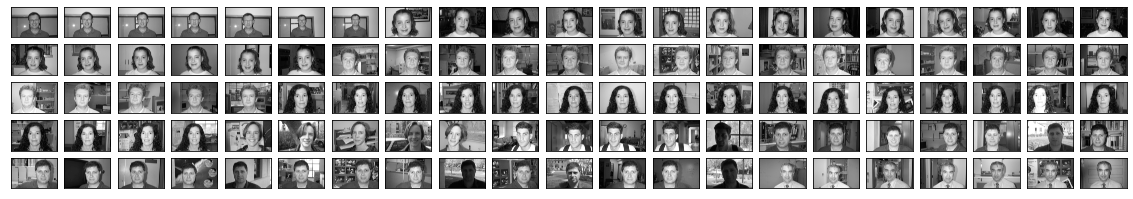

In [5]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [6]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [7]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []

for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE)

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

In [8]:
faces.images.shape

(440, 47, 47, 1)

### 2. Print statistics of data

In [9]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)
imshape

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


(47, 47, 1)

Keys:  dict_keys(['data', 'images', 'labels', 'target'])
data:  [ 53  28  26 ... 185  37  36] , data shape:  (2209,)
label:  person_010
target:  9


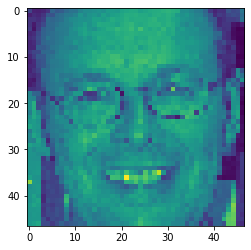

Ground truth labels of the entire dataset: 
 [ 9  9  9  9  9  9  9 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 11 11 11 11 11
 16 16 16 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24

In [10]:
# My investigation
print("Keys: ",faces.keys())

data = faces.get('data')
images = faces.get('images')
labels = faces.get('labels')
target = faces.get('target')

print("data: ",data[0],", data shape: ",data[0].shape)
print("label: ",labels[0])
print("target: ",target[0])
plt.imshow(images[0])
plt.show()

print("Ground truth labels of the entire dataset: \n",faces.target)
print("faces.target shape", faces.target.shape)
print("faces.target type", type(faces.target))

### 3. Visualise some faces

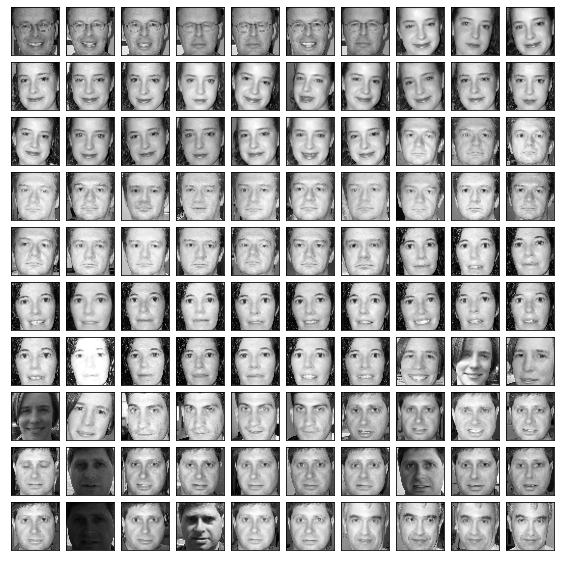

In [11]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [12]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC1 = FeatureDescriptor.LBP
DESC2 = FeatureDescriptor.PCA
DESC3 = FeatureDescriptor.LDA
DESC4 = FeatureDescriptor.DL  # output <FeatureDescriptor.DL: 4>
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [13]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC2 == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)   # descriptor created using PCA
    X_pca = desc.transform(faces.data)
    embedded_PCA = X_pca
    
    dist_metric = euclidean

num_components 35


In [14]:
# Check result on feature descriptor vectors created using Principal Component Analysis
print("embedded_PCA shape: ",embedded_PCA.shape)

"""440 example images. For each image, PCA constructs a feature descriptor vector that consists of 35 components, hence the shape (440,35) of the embedded_PCA array of 1-D arrays"""

embedded_PCA shape:  (440, 35)


'440 example images. For each image, PCA constructs a feature descriptor vector that consists of 35 components, hence the shape (440,35) of the embedded_PCA array of 1-D arrays'

### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC3 == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_LDA = X_lda
    
    dist_metric = euclidean

In [16]:
# Check result on feature descriptor vectors created using Linear Discriminant Analysis
print("embedded_LDA shape: ",embedded_LDA.shape)

"""440 example images. For each image, LDA constructs a feature descriptor vector that consists of 25 components, hence the shape (440,25) of the embedded_LDA array of 1-D arrays"""

embedded_LDA shape:  (440, 25)


'440 example images. For each image, LDA constructs a feature descriptor vector that consists of 25 components, hence the shape (440,25) of the embedded_LDA array of 1-D arrays'

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [17]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

if DESC1 == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_LBP = desc.describe_list(faces.images[...,0])
    
    dist_metric = chisquare
    
# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

In [18]:
# Check result on feature descriptor vectors created using the Local Binary Pattern technique
print("embedded_LBP shape: ",embedded_LBP.shape)

"""440 example images. For each image, LBP constructs a feature descriptor vector that consists of 490 components, hence the shape (440,490) of the embedded_LBP array of 1-D arrays"""

embedded_LBP shape:  (440, 490)


'440 example images. For each image, LBP constructs a feature descriptor vector that consists of 490 components, hence the shape (440,490) of the embedded_LBP array of 1-D arrays'

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you typically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).


In [19]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

2022-05-28 18:49:22.349665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:49:22.430973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:49:22.431732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:49:22.432887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
# To visualize your model structure:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_filer='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [21]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC4 == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_DL = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = euclidean

2022-05-28 18:49:24.987136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-28 18:49:25.913870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


38/38 - 8s - loss: 0.1044 - accuracy: 0.7007 - val_loss: 0.0557 - val_accuracy: 0.8562
Epoch 2/10
38/38 - 1s - loss: 0.0429 - accuracy: 0.9145 - val_loss: 0.0328 - val_accuracy: 0.9688
Epoch 3/10
38/38 - 1s - loss: 0.0245 - accuracy: 0.9737 - val_loss: 0.0234 - val_accuracy: 0.9937
Epoch 4/10
38/38 - 1s - loss: 0.0172 - accuracy: 0.9910 - val_loss: 0.0180 - val_accuracy: 0.9937
Epoch 5/10
38/38 - 1s - loss: 0.0126 - accuracy: 0.9918 - val_loss: 0.0160 - val_accuracy: 0.9969
Epoch 6/10
38/38 - 1s - loss: 0.0100 - accuracy: 0.9959 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 7/10
38/38 - 1s - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 8/10
38/38 - 1s - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 9/10
38/38 - 1s - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 10/10
38/38 - 1s - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0117 - val_accuracy: 0.9937
Accuracy on the test set: 0.99

In [22]:
# Check result on feature descriptor vectors created using the Deep Learning technique 
print("embedded_DL shape: ",embedded_DL.shape)

"""440 example images. For each image, DL constructs a feature descriptor vector that consists of 128 components, hence the shape (440,128) of the embedded_DL array of 1-D arrays"""

embedded_DL shape:  (440, 128)


'440 example images. For each image, DL constructs a feature descriptor vector that consists of 128 components, hence the shape (440,128) of the embedded_DL array of 1-D arrays'

## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In **verification mode** one compares this matching score to a decision threshold in a 1-to-1 setting.
* In **identification mode** one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the **classification scores** (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

In [23]:
def dist2scores2(embedded,faces):
    # embedded has the same length as faces.target because
    # one corresponds to the number_of_feature_vectors = number_of_images in the dataset and the other to the targets of all images

    N_img = len(embedded)  # num_of_images
     
    distances = []
    target_difs = []

    for i, arr1 in enumerate(embedded):
        for j, arr2 in enumerate(embedded):
            distances.append(euclidean(arr1,arr2))  # the feature vectors' distance of two images is calculated here

            dif = faces.target[i]-faces.target[j]
            target_difs.append(dif)
    
    distances = np.array(distances)
    target_difs = np.array(target_difs)
    
    # normalize to [0,1] range, 0 corresponding to maximum similarity since a smaller distance means higher similarity
    norm_distances_inv = 1 - (distances - distances.min())/(distances.max()-distances.min())
        
    # replace all target_diferences with values different than zero with ones (corresponding to non-genuine matching scores)
    labels = np.where(target_difs == 0, target_difs, 1)
    # Invert the array (zeros become ones and vice versa) so than genuine matching pairs correspond to ones and impostor matches correspond to zeros
    labels = (labels+1)%2
    
    return(labels, norm_distances_inv)

In [24]:
# OPTIONAL (extra check)
# Check resulting distance matrix based on feature vectors created using LBP - 
# Diagonal elements should be zeros because at these locations of the matrix each feature descriptor's distance with itself is calculated

#print("Diagonal elements distances_LBP: ",distances_LBP.diagonal())
#print("Diagonal elements distances_PCA: ",distances_PCA.diagonal())
#print("Diagonal elements distances_LDA: ",distances_LDA.diagonal())
#print("Diagonal elements distances_DL: ",distances_DL.diagonal())

#dist_df_LBP
#dist_df_PCA
#dist_df_LDA
#dist_df_DL

In [25]:
# ground truth labels | distance scores
labels_LBP,             scores_LBP  = dist2scores2(embedded_LBP,faces)
labels_PCA,             scores_PCA  = dist2scores2(embedded_PCA,faces)
labels_LDA,             scores_LDA  = dist2scores2(embedded_LDA,faces)
labels_DL,              scores_DL   = dist2scores2(embedded_DL,faces)

## V. Evaluation

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

In [26]:
# Two images are considered to belong to the same person if their feature descriptors do not exceed a distance threshold  

# Classifies genuine and impostor scores according to a specific threshold
def Classifier(threshold,scores):
    classified_scores_labels = np.zeros(len(scores)) # the length of the predicted labels array must be equal to the ground truth labels array
    for i in range(len(scores)):
        if scores[i] >= threshold:   
        #if scores[i] <= threshold:
            classified_scores_labels[i] = 1  # genuine score (label=1)
        elif scores[i] < threshold:
        #elif scores[i] > threshold:
            classified_scores_labels[i] = 0  # impostor score (label=0)
    return classified_scores_labels  

step = 100 #number of different threshold values
thresh = np.linspace(0,1,step)

# Classify the genuine and impostor scores for different thresholds
# y_pred holds the predicted labels of the matching scores
y_pred_LBP = []
y_pred_PCA = []
y_pred_LDA = []
y_pred_DL = []

# For a range of different thresholds, create the label predictions y for every feature extractor
for i,thr in enumerate(thresh):
    y_pred_LBP.append(Classifier(thr,scores_LBP))
    y_pred_PCA.append(Classifier(thr,scores_PCA))
    y_pred_LDA.append(Classifier(thr,scores_LDA))
    y_pred_DL.append(Classifier(thr,scores_DL))
       
y_pred_LBP = np.array(y_pred_LBP)
y_pred_PCA = np.array(y_pred_PCA)
y_pred_LDA = np.array(y_pred_LDA)
y_pred_DL = np.array(y_pred_DL)


In [27]:
# Accuracy and F1-scores are calculated for different threshold values, for each feature extraction method

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Initializations
Accuracy_LBP = np.zeros(step)
Accuracy_PCA = np.zeros(step)
Accuracy_LDA = np.zeros(step)
Accuracy_DL = np.zeros(step)

F1_LBP = np.zeros(step)
F1_PCA = np.zeros(step)
F1_LDA = np.zeros(step)
F1_DL  = np.zeros(step)

# For a range of different thresholds, create the label predictions y for every feature extractor
for i,thr in enumerate(thresh):  
    # Accuracy and F1 score calculation across multiple thresholds - Accuracy is calculated based on the predicted labels and the ground truth labels for the scores
    # Feature Extractor: Local Binary Pattern (LBA)
    Accuracy_LBP[i]= accuracy_score(labels_LBP, y_pred_LBP[i])
    F1_LBP[i] = f1_score(labels_LBP, y_pred_LBP[i])
    
    # Feature Extractor: Principal Component Analysis (PCA)
    Accuracy_PCA[i]= accuracy_score(labels_PCA, y_pred_PCA[i])
    F1_PCA[i] = f1_score(labels_PCA, y_pred_PCA[i])
    
    # Feature Extractor: Linear Discriminant Analysis (LDA)
    Accuracy_LDA[i]= accuracy_score(labels_LDA, y_pred_LDA[i])
    F1_LDA[i] = f1_score(labels_LDA, y_pred_LDA[i])
    
    # Feature Extractor: Deep Learning (DL)
    Accuracy_DL[i]= accuracy_score(labels_DL, y_pred_DL[i])
    F1_DL[i] = f1_score(labels_DL, y_pred_DL[i])

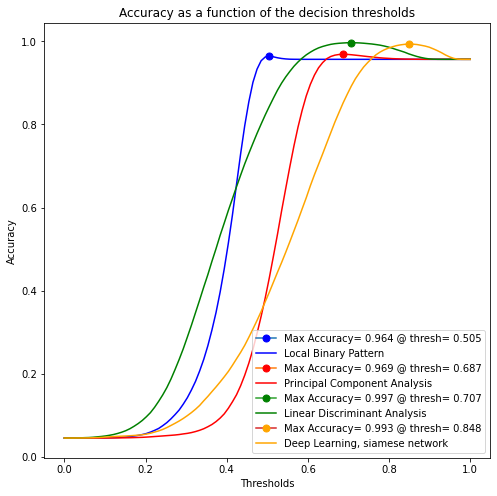

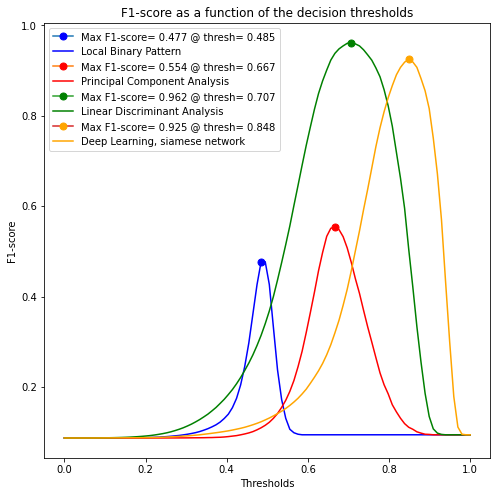

In [28]:
# Thresholds for which F1-scores are maximum for each feature extractor
thr1_F1 = np.argmax(F1_LBP)
thr2_F1 = np.argmax(F1_PCA)
thr3_F1 = np.argmax(F1_LDA)
thr4_F1 = np.argmax(F1_DL)

# Thresholds for which Accuracy is maximum for each feature extractor
thr1_Acc = np.argmax(Accuracy_LBP)
thr2_Acc = np.argmax(Accuracy_PCA)
thr3_Acc = np.argmax(Accuracy_LDA)
thr4_Acc = np.argmax(Accuracy_DL)

plt.rcParams['figure.figsize'] = [8,8]    
plt.title('Accuracy as a function of the decision thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')

plt.plot(thresh[thr1_Acc], Accuracy_LBP[thr1_Acc], marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",
         label="Max Accuracy= "+ str(round(Accuracy_LBP[thr1_Acc],3)) + " @ thresh= " + str(round(thresh[thr1_Acc],3)))
plt.plot(thresh, Accuracy_LBP, color='blue',label="Local Binary Pattern")

plt.plot(thresh[thr2_Acc], Accuracy_PCA[thr2_Acc], marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",
         label="Max Accuracy= "+ str(round(Accuracy_PCA[thr2_Acc],3)) + " @ thresh= " + str(round(thresh[thr2_Acc],3)))
plt.plot(thresh, Accuracy_PCA, color='red',label="Principal Component Analysis")

plt.plot(thresh[thr3_Acc], Accuracy_LDA[thr3_Acc], marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",
        label="Max Accuracy= "+ str(round(Accuracy_LDA[thr3_Acc],3)) + " @ thresh= " + str(round(thresh[thr3_Acc],3)))
plt.plot(thresh, Accuracy_LDA, color='green',label="Linear Discriminant Analysis")

plt.plot(thresh[thr4_Acc], Accuracy_DL[thr4_Acc], marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",
        label="Max Accuracy= "+ str(round(Accuracy_DL[thr4_Acc],3)) + " @ thresh= " + str(round(thresh[thr4_Acc],3)))
plt.plot(thresh, Accuracy_DL, color='orange',label="Deep Learning, siamese network")

plt.legend(loc="lower right")
plt.show() 

#---------------------------------------------------------------------------
plt.title('F1-score as a function of the decision thresholds')
plt.xlabel('Thresholds')
plt.ylabel('F1-score')

plt.plot(thresh[thr1_F1], F1_LBP[thr1_F1], marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",
         label="Max F1-score= "+ str(round(F1_LBP[thr1_F1],3)) + " @ thresh= " + str(round(thresh[thr1_F1],3)))
plt.plot(thresh, F1_LBP, color='blue',label="Local Binary Pattern")

plt.plot(thresh[thr2_F1], F1_PCA[thr2_F1], marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",
        label="Max F1-score= "+ str(round(F1_PCA[thr2_F1],3)) + " @ thresh= " + str(round(thresh[thr2_F1],3)))
plt.plot(thresh, F1_PCA, color='red',label="Principal Component Analysis")

plt.plot(thresh[thr3_F1], F1_LDA[thr3_F1], marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",
        label="Max F1-score= "+ str(round(F1_LDA[thr3_F1],3)) + " @ thresh= " + str(round(thresh[thr3_F1],3)))
plt.plot(thresh, F1_LDA, color='green',label="Linear Discriminant Analysis")

plt.plot(thresh[thr4_F1], F1_DL[thr4_F1], marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",
        label="Max F1-score= "+ str(round(F1_DL[thr4_F1],3)) + " @ thresh= " + str(round(thresh[thr4_F1],3)))
plt.plot(thresh, F1_DL, color='orange',label="Deep Learning, siamese network")

plt.legend(loc="upper left")
plt.show() 

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

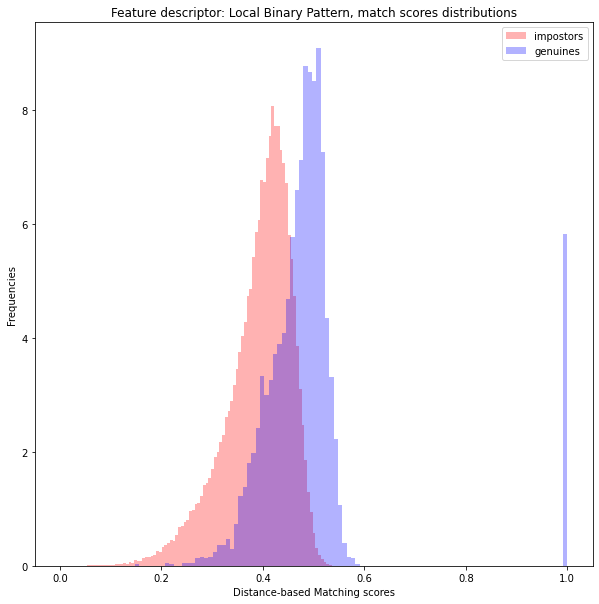

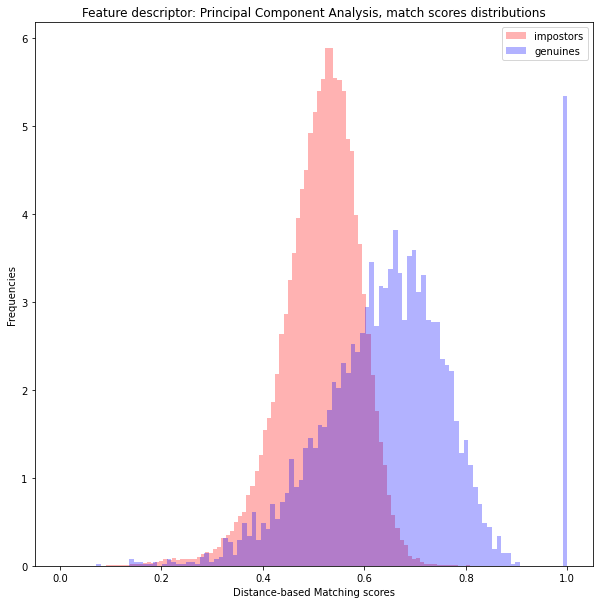

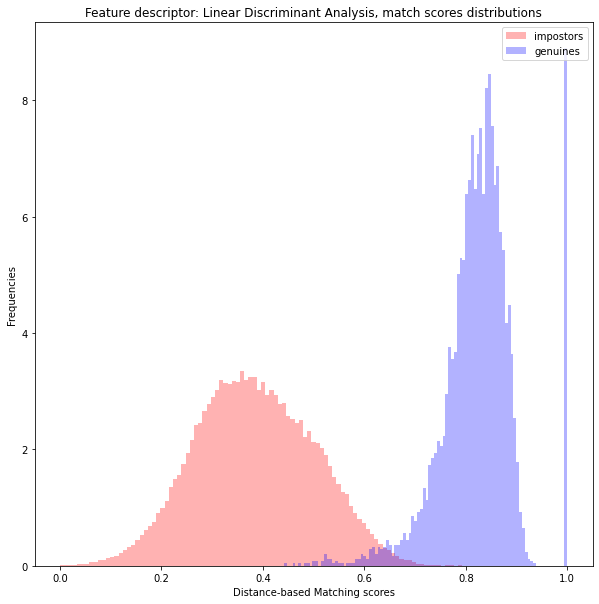

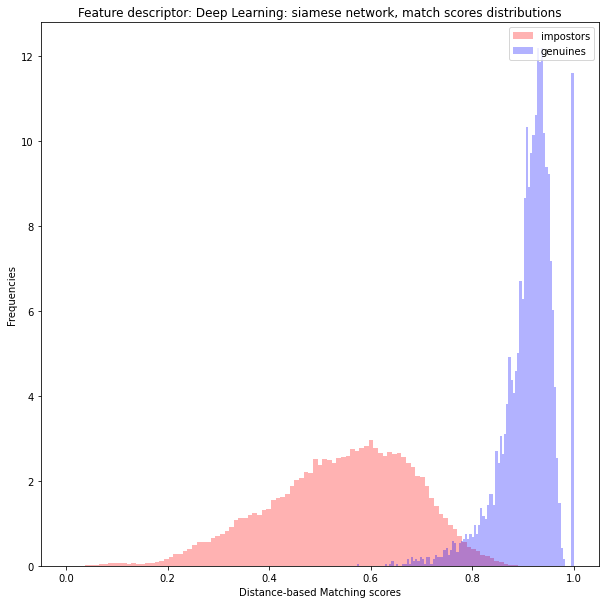

length scores_DL 193600
length impostors_DL 184740
length genuines_DL 8860


In [29]:
plt.rcParams['figure.figsize'] = [10,10]

plt.title('Feature descriptor: Local Binary Pattern, match scores distributions') # The highest the score/distance, the less similar the images
plt.xlabel('Distance-based Matching scores')
plt.ylabel('Frequencies')
plt.hist(scores_LBP[labels_LBP==0],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="impostors",color="red") 
plt.hist(scores_LBP[labels_LBP==1],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="genuines",color="blue") 
plt.legend(loc="upper right")
plt.show()

plt.title('Feature descriptor: Principal Component Analysis, match scores distributions') # The highest the score/distance, the less similar the images
plt.xlabel('Distance-based Matching scores')
plt.ylabel('Frequencies')
plt.hist(scores_PCA[labels_PCA==0],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="impostors",color="red") 
plt.hist(scores_PCA[labels_PCA==1],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="genuines",color="blue") 
plt.legend(loc="upper right")
plt.show()

plt.title('Feature descriptor: Linear Discriminant Analysis, match scores distributions') # The highest the score/distance, the less similar the images
plt.xlabel('Distance-based Matching scores')
plt.ylabel('Frequencies')
plt.hist(scores_LDA[labels_LDA==0],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="impostors",color="red") 
plt.hist(scores_LDA[labels_LDA==1],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="genuines",color="blue") 
plt.legend(loc="upper right")
plt.show()

plt.title('Feature descriptor: Deep Learning: siamese network, match scores distributions') # The highest the score/distance, the less similar the images
plt.xlabel('Distance-based Matching scores')
plt.ylabel('Frequencies')
plt.hist(scores_DL[labels_DL==0],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="impostors",color="red") 
plt.hist(scores_DL[labels_DL==1],bins=100,histtype='stepfilled', alpha=0.3,density=True,label="genuines",color="blue") 
plt.legend(loc="upper right")
plt.show()

print("length scores_DL", len(scores_DL))
print("length impostors_DL",len(scores_DL[labels_DL==0]))
print("length genuines_DL",len(scores_DL[labels_DL==1]))

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hints: 
* Calculate and plot the equal error rate. 
* Plot the precision-recall curve and 
* compute AUC and average precision. 
Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

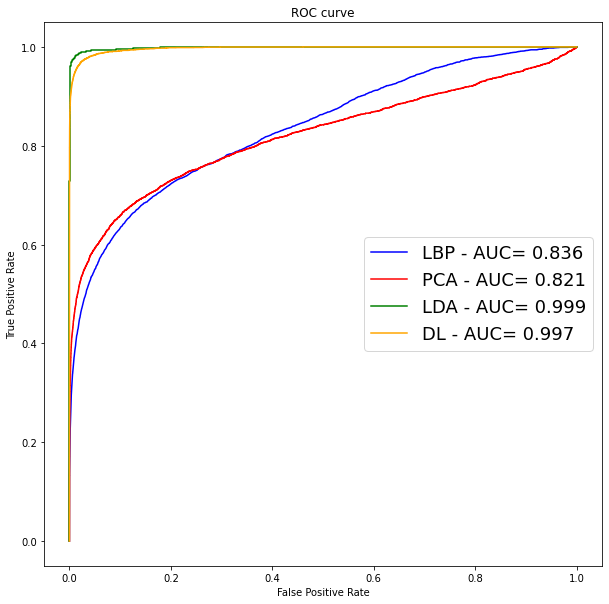

In [30]:
# ROC Curves

import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#from sklearn.metrics import from_predictions

#                                      ground truth labels  | predicted labels
fpr_LBP, tpr_LBP, thresholds = roc_curve(labels_LBP, scores_LBP) 

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_LBP, tpr_LBP, color='blue',label="LBP - AUC= " + str(round(auc(fpr_LBP, tpr_LBP),3)))

fpr_PCA, tpr_PCA, thresholds = roc_curve(labels_PCA, scores_PCA) 
plt.plot(fpr_PCA, tpr_PCA, color='red',label="PCA - AUC= " + str(round(auc(fpr_PCA, tpr_PCA),3)))

fpr_LDA, tpr_LDA, thresholds = roc_curve(labels_LDA, scores_LDA) 
plt.plot(fpr_LDA, tpr_LDA, color='green',label="LDA - AUC= " + str(round(auc(fpr_LDA, tpr_LDA),3)))

fpr_DL, tpr_DL, thresholds = roc_curve(labels_DL, scores_DL) 
plt.plot(fpr_DL, tpr_DL, color='orange',label="DL - AUC= " + str(round(auc(fpr_DL, tpr_DL),3)))

plt.legend(loc="right",prop={'size': 18})
plt.show()

In [31]:
# AUC Calculation - for ROC curves
from sklearn.metrics import auc

print("AUC_LBP = ",auc(fpr_LBP, tpr_LBP))
print("AUC_PCA = ",auc(fpr_PCA, tpr_PCA))
print("AUC_LDA = ",auc(fpr_LDA, tpr_LDA))
print("AUC_DL = ",auc(fpr_DL, tpr_DL))

AUC_LBP =  0.8360370269631581
AUC_PCA =  0.8205176159967117
AUC_LDA =  0.9985721131840222
AUC_DL =  0.9968693186275336


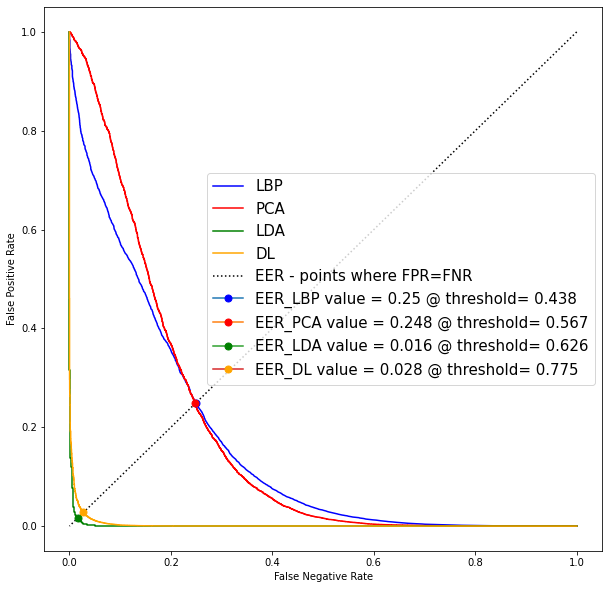

In [32]:
# Calculation of EER points and corresponding thresholds

fpr_LBP, tpr_LBP, thresholds_LBP = roc_curve(labels_LBP, scores_LBP) 
fnr_LBP = 1 - tpr_LBP
plt.xlabel('False Negative Rate')
plt.ylabel('False Positive Rate')
plt.plot(fnr_LBP, fpr_LBP, color='blue',label="LBP")

fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(labels_PCA, scores_PCA) 
fnr_PCA = 1 - tpr_PCA
plt.plot(fnr_PCA, fpr_PCA, color='red',label="PCA")

fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(labels_LDA, scores_LDA) 
fnr_LDA = 1 - tpr_LDA
plt.plot(fnr_LDA, fpr_LDA, color='green',label="LDA")

fpr_DL, tpr_DL, thresholds_DL = roc_curve(labels_DL, scores_DL) 
fnr_DL = 1 - tpr_DL
plt.plot(fnr_DL, fpr_DL, color='orange',label="DL")

# EER line- where FNR equals FPR
plt.plot(fnr_DL, fnr_DL, linestyle='dotted',color='black',label="EER - points where FPR=FNR")


# Equal Error Rate points (only one coordinate needed since FPR=FNR for the EER points)
EER_LBP = fpr_LBP[np.nanargmin(np.absolute((fnr_LBP - fpr_LBP)))]
thr_EER_LBP = thresholds_LBP[np.nanargmin(np.absolute((fnr_LBP - fpr_LBP)))]

EER_PCA = fpr_PCA[np.nanargmin(np.absolute((fnr_PCA - fpr_PCA)))]
thr_EER_PCA = thresholds_PCA[np.nanargmin(np.absolute((fnr_PCA - fpr_PCA)))]

EER_LDA = fpr_LDA[np.nanargmin(np.absolute((fnr_LDA - fpr_LDA)))]
thr_EER_LDA = thresholds_LDA[np.nanargmin(np.absolute((fnr_LDA - fpr_LDA)))]

EER_DL = fpr_DL[np.nanargmin(np.absolute((fnr_DL - fpr_DL)))]
thr_EER_DL = thresholds_DL[np.nanargmin(np.absolute((fnr_DL - fpr_DL)))]

# EER points
plt.plot(EER_LBP, EER_LBP, marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",label = "EER_LBP value = "+str(round(EER_LBP,3))+" @ threshold= "+ str(round(thr_EER_LBP,3)))
plt.plot(EER_PCA, EER_PCA, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",label = "EER_PCA value = "+str(round(EER_PCA,3))+" @ threshold= "+ str(round(thr_EER_PCA,3)))
plt.plot(EER_LDA, EER_LDA, marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",label = "EER_LDA value = "+str(round(EER_LDA,3))+" @ threshold= "+ str(round(thr_EER_LDA,3)))
plt.plot(EER_DL, EER_DL, marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",label = "EER_DL value = "+str(round(EER_DL,3))+" @ threshold= "+ str(round(thr_EER_DL,3)))

plt.legend(loc="right",prop={'size': 15})
plt.show()

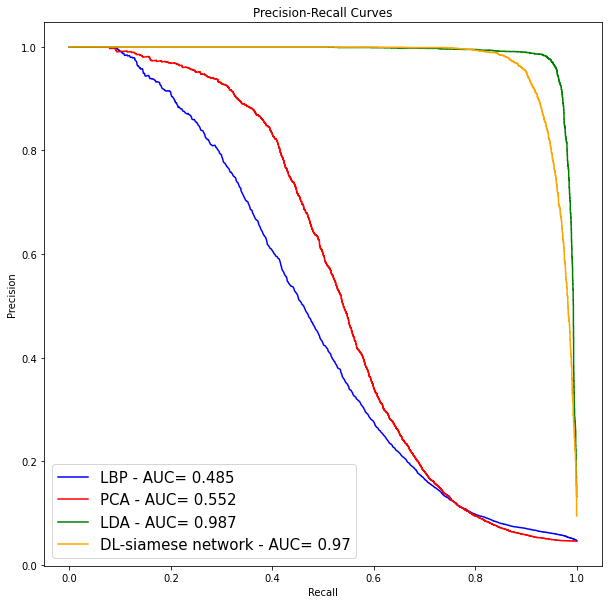

In [33]:
# Precision-Recall Curves
from sklearn.metrics import precision_recall_curve

Precision_LBP, Recall_LBP, Thresholds_LBP = precision_recall_curve(labels_LBP, scores_LBP)
Precision_PCA, Recall_PCA, Thresholds_PCA = precision_recall_curve(labels_PCA, scores_PCA)
Precision_LDA, Recall_LDA, Thresholds_LDA = precision_recall_curve(labels_LDA, scores_LDA)
Precision_DL, Recall_DL, Thresholds_DL = precision_recall_curve(labels_DL, scores_DL)


plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(Recall_LBP, Precision_LBP, color='blue',label="LBP - AUC= "+str(round(auc(Recall_LBP, Precision_LBP),3)))
plt.plot(Recall_PCA, Precision_PCA, color='red',label="PCA - AUC= "+str(round(auc(Recall_PCA, Precision_PCA),3)))
plt.plot(Recall_LDA, Precision_LDA, color='green',label="LDA - AUC= "+str(round(auc(Recall_LDA, Precision_LDA),3)))
plt.plot(Recall_DL, Precision_DL, color='orange',label="DL-siamese network - AUC= "+str(round(auc(Recall_DL, Precision_DL),3)))
plt.legend(loc="lower left",prop={'size': 15})
plt.show()

In [34]:
# Average Precision calculation for each feature extraction method
from sklearn.metrics import average_precision_score

AVG_Prec_Score_LBP = average_precision_score(labels_LBP, scores_LBP)
print("Average Precision Score LBP: ",round(AVG_Prec_Score_LBP,6))

AVG_Prec_Score_PCA = average_precision_score(labels_PCA, scores_PCA)
print("Average Precision Score PCA: ",round(AVG_Prec_Score_PCA,6))

AVG_Prec_Score_LDA = average_precision_score(labels_LDA, scores_LDA)
print("Average Precision Score LDA: ",round(AVG_Prec_Score_LDA,6))

AVG_Prec_Score_DL = average_precision_score(labels_DL, scores_DL)
print("Average Precision Score DL-siamese network: ",round(AVG_Prec_Score_DL,6))

Average Precision Score LBP:  0.484704
Average Precision Score PCA:  0.551886
Average Precision Score LDA:  0.986532
Average Precision Score DL-siamese network:  0.970148


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [36]:
# Calculate distance matrices for each feature extraction method

distance_matrix_LBP = np.zeros((embedded_LBP.shape[0],embedded_LBP.shape[0]))
for i in range(embedded_LBP.shape[0]):
    for j in range(embedded_LBP.shape[0]):
        distance_matrix_LBP[i,j] = euclidean(embedded_LBP[i],embedded_LBP[j])  # the feature vectors' distance of two images is calculated here

distance_matrix_PCA = np.zeros((embedded_PCA.shape[0],embedded_PCA.shape[0]))
for i in range(embedded_PCA.shape[0]):
    for j in range(embedded_PCA.shape[0]):
        distance_matrix_PCA[i,j] = euclidean(embedded_PCA[i],embedded_PCA[j])  # the feature vectors' distance of two images is calculated here

distance_matrix_LDA = np.zeros((embedded_LDA.shape[0],embedded_LDA.shape[0]))
for i in range(embedded_LDA.shape[0]):
    for j in range(embedded_LDA.shape[0]):
        distance_matrix_LDA[i,j] = euclidean(embedded_LDA[i],embedded_LDA[j])  # the feature vectors' distance of two images is calculated here

distance_matrix_DL = np.zeros((embedded_DL.shape[0],embedded_DL.shape[0]))
for i in range(embedded_DL.shape[0]):
    for j in range(embedded_DL.shape[0]):
        distance_matrix_DL[i,j] = euclidean(embedded_DL[i],embedded_DL[j])  # the feature vectors' distance of two images is calculated here
        
print(distance_matrix_LBP.shape)
print(distance_matrix_PCA.shape)
print(distance_matrix_LDA.shape)
print(distance_matrix_DL.shape)


(440, 440)
(440, 440)
(440, 440)
(440, 440)


In [92]:
# The goal here is to calculate a similarity matrix between all classes of the dataset
# In other words, to construct a 26x16 matrix where each cell contains the similarity between two classes of the dataset.

# The similarity matrix found above can be used to plot the cmc curve.

## Task 6 - Deep Learning Neural Network - Residual Network (ResNet)

### RESNET50 ARCHITECTURE

Deep Residual Learning for Image Recognition  

**ResNet 50** is a current state of the art convolutional neural network architecture that is used as a backbone for many computer vision applications like object detection, image segmentation, etc.
ResNet is a short name for a **residual deep learning neural network** model with **50 layers**.
The approach behind this network follows the idea that instead of layers learn the underlying mapping we allow network fit the residual mapping. 
Τhe building blocks are modified into a **bottleneck design** due to concerns over the time taken to train the layers.
Since Deeper neural networks are more difficult to train, a **residual learning framework** can be a solution when training a network that is substantially deeper than the used previously (VGG16). 
The layers are explicitly reformulated as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. 
These residual networks are easier to optimize, and can gain accuracy from considerably increased depth. 
The advantage of adding this type of skip connection is because if any layer negatively impacts the performance of the architecture, then it will be skipped by regularization. 
Deep networks extract **low**, **middle** and **high-level features** and **classifiers** in an end-to-end multi-layer fashion and the number of stacked layers can enrich the levels of features.

<img src = "https://drive.google.com/uc?export=view&id=1J0rvtzcAUOg1yjoyA8-gvcvVQhf-YhFA" width="1400" height="100">

In [64]:
# Data Preparation to fit the input requirements of the ResNet

face_size_res=(224, 224) 

# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs_res = [read_img(imagePath) for imagePath in imagePaths]
data_res = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data_res['images']) == len(data_res['target']) == 445

images_res = [] ; labels_res = []

for img_res, label_res in zip(data_res['images'], data_res['target']):
    faces_res = faceCascade.detectMultiScale(img_res, scaleFactor = 1.2, minNeighbors = 9, minSize = (30, 30), flags = cv2.CASCADE_SCALE_IMAGE)
    # iterate faces found in image
    for (x, y, w, h) in faces_res:
        new_img_res = img_res.copy()
        # extract ROI
        raw_face_res = new_img_res[y:y+h, x:x+w]
        # resize the face to the preferred size
        face_res = cv2.resize(raw_face_res, face_size_res)
        #convert images to BGR
        face_res = cv2.cvtColor(face_res, cv2.COLOR_GRAY2BGR)   
        images_res.append(np.expand_dims(face_res, axis=-1))
        labels_res.append(label_res)

# encode classes as integer value
targets_res = label_encoder.fit_transform(labels_res)
faces_res = Bunch(images_res     = np.array(images_res), 
                  labels_res     = np.array(labels_res),
                  target_res     = np.array(targets_res))

In [65]:
print("faces_res.images_res shape: ",faces_res.images_res.shape)
print("faces_res.target_res shape: ",faces_res.target_res.shape)

Y_train_final = np.array(faces_res.target_res)
new_arr = []
for i in range(len(Y_train_final)):
    new_arr.append([Y_train_final[i]])
np.transpose(new_arr)
Y_train_final = np.array(new_arr)
#Y_train_final = np.squeeze(Y_train_final,axis=1)
print("Y_train_final shape: ",Y_train_final.shape)

# Construction of onehot labeling system
# labels is a 440*26 matrix holding a label array for each image (440 images - 26 classes)
# each array has 1 only in the position that corresponds to the class the face of the image belongs to
# the rest of its elements are 0
labels = np.zeros((len(faces_res.images_res),26),dtype=int)
for i in range(len(faces_res.target_res)):
    ind = faces_res.target_res[i]
    labels[i,ind] = 1

Y_train_final = labels

faces_res.images_res shape:  (440, 224, 224, 3, 1)
faces_res.target_res shape:  (440,)
Y_train_final shape:  (440, 1)


In [66]:
def normalizeData(img_data):
    # This function normalizes the given datasets
    normalized_imgs = img_data.astype(np.float32) / 255
    return normalized_imgs

# Resize the images from the training set
X_train_img_list = np.squeeze(faces_res.images_res,axis=-1)

# Normalization of the training data
X_final_img_train = normalizeData(X_train_img_list)

print("X_final_img_train shape",X_final_img_train.shape)
print("y_train_final shape",Y_train_final.shape,"\n")

X_final_img_train shape (440, 224, 224, 3)
y_train_final shape (440, 26) 



In [67]:
#plt.imshow(X_final_img_train[0])
#plt.show()
Y_train_final

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [68]:
import tensorflow as tf

# OPTIMIZER-----------
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001, # changed from 0.0001
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")

# RESNET
input_layer = tf.keras.Input(shape = (224, 224, 3))
base_model = tf.keras.applications.ResNet50(include_top = False,
                                            weights = 'imagenet',
                                            input_tensor = input_layer,
                                            pooling = 'avg')

# Add FC layers for the final classification
dense_1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(base_model.output)
dense_2 = tf.keras.layers.Dense(units = 256,  activation = 'relu')(dense_1)

dense_final = tf.keras.layers.Dense(units = 26, activation = 'softmax')(dense_2) #--gave good results
#dense_final = tf.keras.layers.Dense(units = 26, activation = 'sigmoid')(dense_2)

model_resnet = tf.keras.Model(inputs = input_layer, outputs = dense_final)

# Experimentation with freezing all layers except for the last one so it can still be trained to detect 20 classes instead of the default 1000
# BEWARE: using this piece of code will most likely reduce the val_accuracy
#for layer in model_resnet.layers[:175]:
#   layer.trainable = False

model_resnet.compile(optimizer = Adam, loss="categorical_crossentropy",metrics=["accuracy"])

94781440/94765736 [==============================] - 1s 0us/step


In [69]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Since the total number of available images to train the deep convolutional neural network, we keep only 10% of the dataset as test_set and 10% as validation set.
holdout_split2 = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

# the dataset is split into 75% training and 25% testing set 
x_train, x_test, y_train, y_test = holdout_split2(X_final_img_train, Y_train_final)

# Checkpoints - callback to save the model & weights 
# checkpoint_path = '../../../working/resnet_model.hdf5'
# checkpointer = ModelCheckpoint(filepath = checkpoint_path,verbose = 1, save_best_only = True)

# The deep convolutional network is trained for 50 epochs 
history_resnet2 = model_resnet.fit(x_train, y_train, validation_split=0.1, batch_size=16, verbose=2, epochs=100)
    
test_scores = model_resnet.predict(x_test)
# the accuracy calculation function as implemented in 
test_acc = siamese.accuracy(y_test, test_scores > 0.5)

Epoch 1/100
19/19 - 8s - loss: 2.0786 - accuracy: 0.5320 - val_loss: 3.3229 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 - 2s - loss: 0.2781 - accuracy: 0.9562 - val_loss: 3.4486 - val_accuracy: 0.0000e+00
Epoch 3/100
19/19 - 2s - loss: 0.0327 - accuracy: 1.0000 - val_loss: 4.1685 - val_accuracy: 0.0000e+00
Epoch 4/100
19/19 - 2s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 4.2851 - val_accuracy: 0.0000e+00
Epoch 5/100
19/19 - 2s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 4.4875 - val_accuracy: 0.0000e+00
Epoch 6/100
19/19 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.8164 - val_accuracy: 0.0000e+00
Epoch 7/100
19/19 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.1286 - val_accuracy: 0.0000e+00
Epoch 8/100
19/19 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 5.4494 - val_accuracy: 0.0000e+00
Epoch 9/100
19/19 - 2s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.9122 - val_accuracy: 0.0000e+00
Epoch 10/100
19/19 - 2s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 6.3

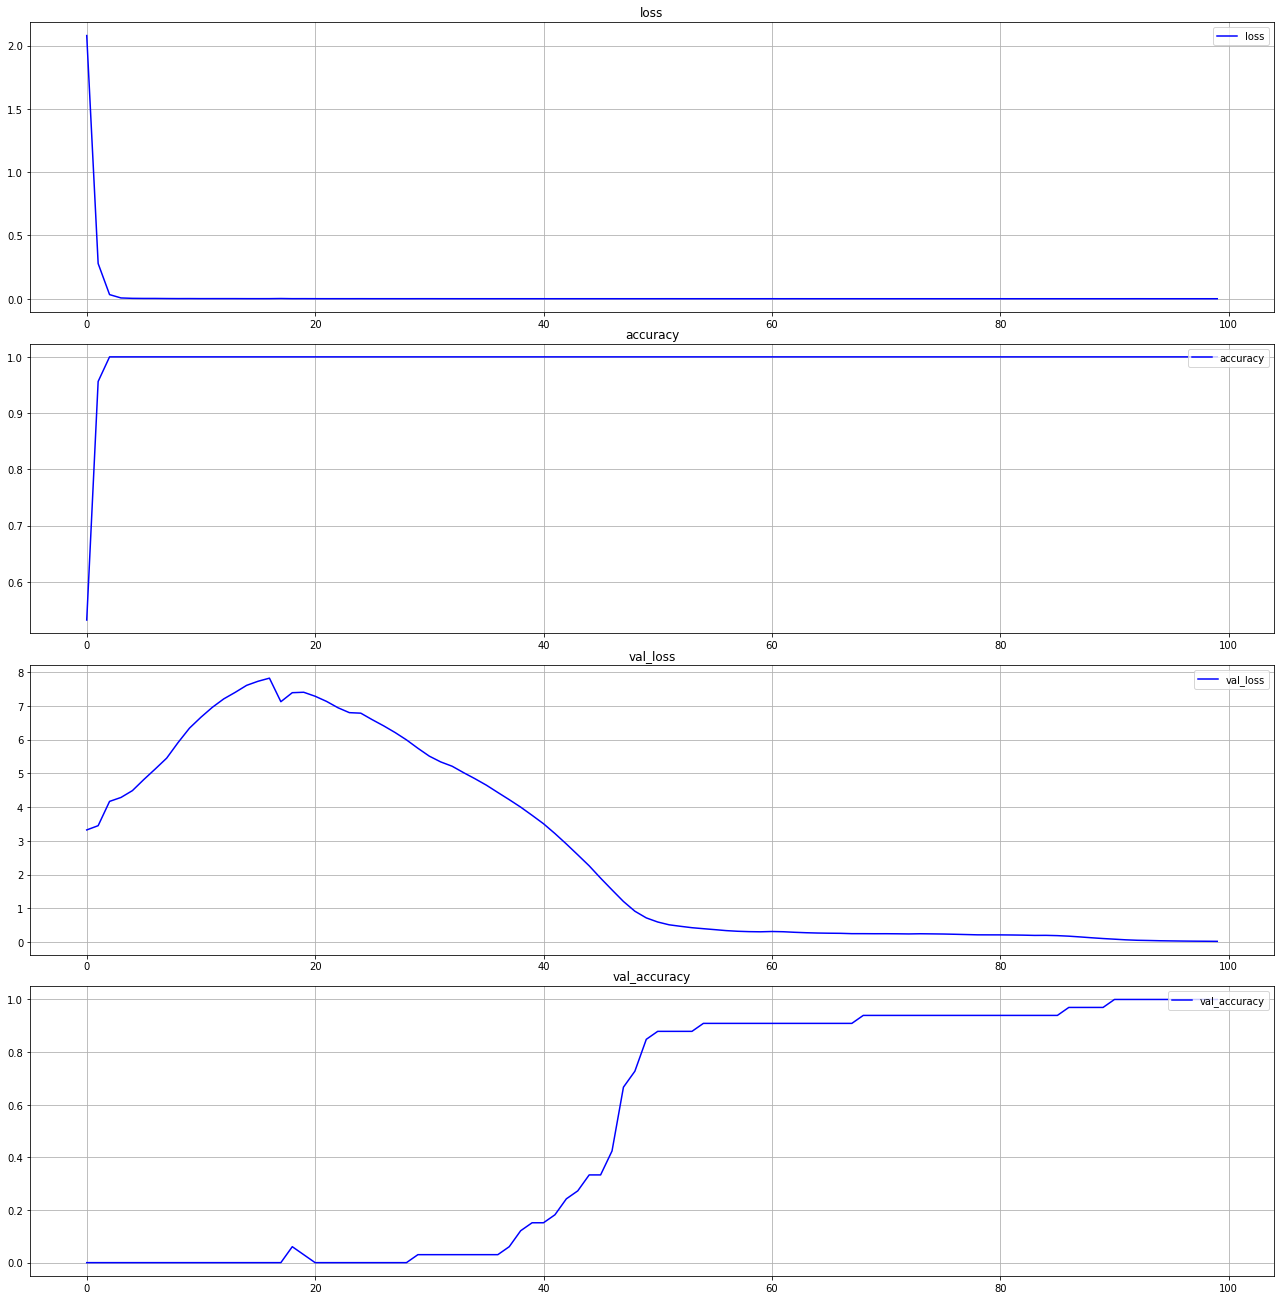

In [70]:
# DISPLAY TRAINING HISTORY
# In this part, a function to print the training history of the network in a compact way is created

import json
def train_hist_dict_plotter(history):
    # This function gets the training history of the training as a dictionary and plots all of its values
    fig, axarr = plt.subplots(len(history), 1, figsize=(18,18))
    fig.tight_layout()
    i = 0

    for attribute,value in list(history.items()):
        axarr[i].plot(range(len(list(history.items())[i][1])), list(history.items())[i][1], 'b')
        axarr[i].set_title(list(history.items())[i][0])
        axarr[i].grid()
        labels = [attribute]
        axarr[i].legend(labels, loc='upper right')
        i += 1
        
train_hist_dict_plotter(history_resnet2.history)

In [71]:
#train_hist_dict_plotter(history_resnet2.history)

print("Accuracy in predictions on the labels of the test set images: ",test_acc)

Accuracy in predictions on the labels of the test set images:  tf.Tensor(0.9965035, shape=(), dtype=float32)


We observe that initially the network can accuratelly predict the labels of the training set but not the ones of the images belonging to the validation set. Therefore, the network starts with an overfit state but it later adapts the weights in order to generalize better and accuratelly predict the labels of the validation set as well.
As we can 

## Task 1 - Evaluate your system on the other two datasets (AT&T, LFW)

The same process as in the steps above is repeated for two different datasets.

## LFW_people Dataset - FEATURE EXTRACTION

In [72]:
# Examine the dataset

from sklearn.datasets import fetch_lfw_people

lfw_dataset = fetch_lfw_people(resize=0.4, min_faces_per_person = 50)
number_samples_lfw, height, width = lfw_dataset.images.shape

# extract number of samples and image dimensions (for later display)
imshape = (height, width)

# count number of individuals
n_classes = lfw_dataset.target.max() +1

n_features = lfw_dataset.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % number_samples_lfw)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)
print("Images Size: "+"height="+str(height)+" width="+str(width))
lfw_dataset.keys()

Total dataset size:
n_samples: 1560
n_classes: 12
n_features: 1850
Images Size: height=50 width=37


dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

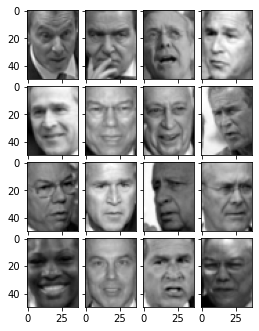

In [73]:
# Examine some of the data 
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 222,
                 nrows_ncols=(4, 4), 
                 axes_pad=0.1)

for ax, im in zip(grid, lfw_dataset['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')

In [74]:
from localmodules.local_binary_patterns import LBP

# LBP feature extraction of the LFW_people Dataset images 
desc_LBP_lfw = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_LBP_lfw = desc_LBP_lfw.describe_list(lfw_dataset.images)
print("LBP feature descriptors' array or arrays shape",embedded_LBP_lfw.shape)

LBP feature descriptors' array or arrays shape (1560, 490)


PCA num_components 11
PCA feature descriptors' array or arrays shape (1560, 11)


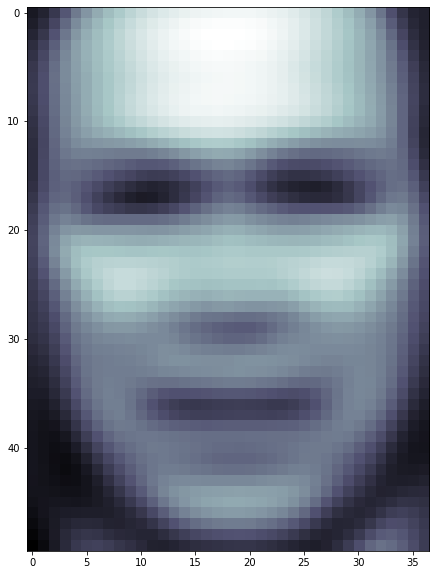

In [75]:
# PCA feature extraction of the LFW_people Dataset images 
num_components_PCA = min(num_components, min(n_classes - 1, n_features))     

print("PCA num_components {n}".format(n=num_components_PCA))

desc_PCA_lfw= PCA(n_components = num_components_PCA, svd_solver='randomized', whiten=True).fit(lfw_dataset.data)
embedded_PCA_lfw = desc_PCA_lfw.transform(lfw_dataset.data)
print("PCA feature descriptors' array or arrays shape",embedded_PCA_lfw.shape)

#Mean face with PCA with LFW dataset
plt.imshow(desc_PCA_lfw.mean_.reshape(lfw_dataset.images[0].shape), cmap=plt.cm.bone)

In [76]:
# LDA feature extraction of the LFW_people Dataset images 
print("Number of images in the LFW_people Dataset= ",len(lfw_dataset.images))

num_components_LDA = min(num_components, min(n_classes - 1, n_features))
print("LDA num_components= {n}".format(n=num_components_LDA))

desc_LDA_lfw = LinearDiscriminantAnalysis(n_components = num_components_LDA).fit(lfw_dataset.data, lfw_dataset.target)
X_LDA = desc_LDA_lfw.fit_transform(lfw_dataset.data, lfw_dataset.target)
embedded_LDA_lfw = X_lda
print("LDA feature descriptors' array or arrays shape",embedded_LDA_lfw.shape)

Number of images in the LFW_people Dataset=  1560
LDA num_components= 11
LDA feature descriptors' array or arrays shape (440, 25)


In [77]:
# Preparing images from the LFW dataset to train the siamese network with and extract feature arrays

feat_data_DL, images_DL, labels_DL = [], [], []

faces_DL = lfw_dataset.images
face_size = (47,47)

for face,label in zip(faces_DL,lfw_dataset.target):
    # iterate faces found in image
    face = cv2.resize(face, face_size)
    face_flatten = face.flatten()
    images_DL.append(np.expand_dims(face, axis=-1)), feat_data_DL.append(face_flatten), labels_DL.append(label)

# encode classes as integer value
targets_DL = label_encoder.fit_transform(labels_DL)

faces_lfw_DL = Bunch(data       = np.array(feat_data_DL), 
                     images     = np.array(images_DL), 
                     labels     = np.array(labels_DL),
                     target     = np.array(targets_DL))

print("faces_lfw_DL.images shape= ",faces_lfw_DL.images.shape)

faces_lfw_DL.images shape=  (1560, 47, 47, 1)


In [78]:
# DL - siamese network feature extraction of the LFW_people Dataset images 
import localmodules.siamese as siamese

imshape = (47,47,1)
encoder, model_LFW = siamese.create_siamese_model(imshape)
#model_LFW.summary()
x_train_LFW, x_test_LFW, y_train_LFW, y_test_LFW = holdout_split(*siamese.get_siamese_paired_data(faces_lfw_DL.images, lfw_dataset.target))

model_LFW.compile(
    loss=siamese.contrastive_loss, 
    optimizer= 'Adam', 
    metrics = [siamese.accuracy],
    run_eagerly=True)

epochs = 10
model_LFW.fit([x_train_LFW[:, 0], x_train_LFW[:, 1]], y_train_LFW, 
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

test_scores_LFW = model_LFW.predict([x_test_LFW[:, 0], x_test_LFW[:, 1]])
test_acc_LFW = accuracy_score(y_test_LFW, test_scores_LFW > 0.5)
print("Accuracy on the test set: {}".format(test_acc_LFW))

embedded_DL_LFW = encoder(faces_lfw_DL.images.astype(np.float32)).numpy()
print("DL-siamese network feature descriptors' array or arrays shape",embedded_DL_LFW.shape)

Epoch 1/10
38/38 - 1s - loss: 0.1354 - accuracy: 0.5395 - val_loss: 0.1357 - val_accuracy: 0.5656
Epoch 2/10
38/38 - 1s - loss: 0.1163 - accuracy: 0.6176 - val_loss: 0.1111 - val_accuracy: 0.6083
Epoch 3/10
38/38 - 1s - loss: 0.0953 - accuracy: 0.7146 - val_loss: 0.1004 - val_accuracy: 0.6698
Epoch 4/10
38/38 - 1s - loss: 0.0791 - accuracy: 0.7919 - val_loss: 0.0974 - val_accuracy: 0.6677
Epoch 5/10
38/38 - 1s - loss: 0.0717 - accuracy: 0.8339 - val_loss: 0.0980 - val_accuracy: 0.7104
Epoch 6/10
38/38 - 1s - loss: 0.0650 - accuracy: 0.8569 - val_loss: 0.0896 - val_accuracy: 0.7437
Epoch 7/10
38/38 - 1s - loss: 0.0563 - accuracy: 0.9054 - val_loss: 0.0934 - val_accuracy: 0.7333
Epoch 8/10
38/38 - 1s - loss: 0.0491 - accuracy: 0.9301 - val_loss: 0.0902 - val_accuracy: 0.7490
Epoch 9/10
38/38 - 1s - loss: 0.0444 - accuracy: 0.9457 - val_loss: 0.0896 - val_accuracy: 0.7375
Epoch 10/10
38/38 - 1s - loss: 0.0398 - accuracy: 0.9613 - val_loss: 0.0896 - val_accuracy: 0.7396
Accuracy on the tes

## LFW Dataset - Evaluation

In [79]:
# ground truth labels | distance scores
labels_LBP_LFW,             scores_LBP_LFW  = dist2scores2(embedded_LBP_lfw,faces_lfw_DL)
labels_PCA_LFW,             scores_PCA_LFW  = dist2scores2(embedded_PCA_lfw,faces_lfw_DL)
labels_LDA_LFW,             scores_LDA_LFW  = dist2scores2(embedded_LDA_lfw,faces_lfw_DL)
labels_DL_LFW,              scores_DL_LFW   = dist2scores2(embedded_DL_LFW,faces_lfw_DL)

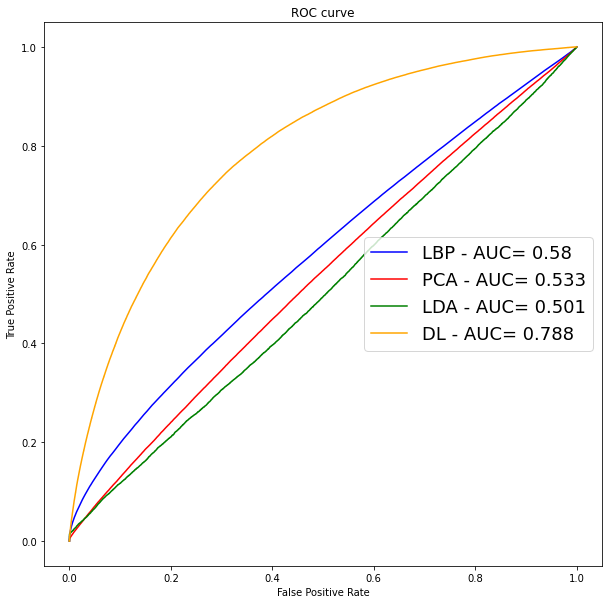

AUC_LBP =  0.5796418310667051
AUC_PCA =  0.5333307453537759
AUC_LDA =  0.501350987567303
AUC_DL =  0.7880355005158899


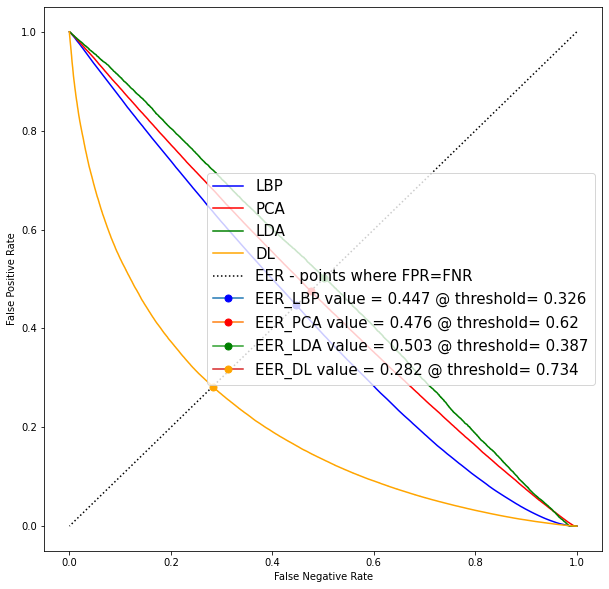

In [80]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#from sklearn.metrics import from_predictions

#                                      ground truth labels  | predicted labels
fpr_LBP, tpr_LBP, thresholds = roc_curve(labels_LBP_LFW, scores_LBP_LFW) # 

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_LBP, tpr_LBP, color='blue',label="LBP - AUC= " + str(round(auc(fpr_LBP, tpr_LBP),3)))

fpr_PCA, tpr_PCA, thresholds = roc_curve(labels_PCA_LFW, scores_PCA_LFW) 
plt.plot(fpr_PCA, tpr_PCA, color='red',label="PCA - AUC= " + str(round(auc(fpr_PCA, tpr_PCA),3)))

fpr_LDA, tpr_LDA, thresholds = roc_curve(labels_LDA_LFW, scores_LDA_LFW) 
plt.plot(fpr_LDA, tpr_LDA, color='green',label="LDA - AUC= " + str(round(auc(fpr_LDA, tpr_LDA),3)))

fpr_DL, tpr_DL, thresholds = roc_curve(labels_DL_LFW, scores_DL_LFW) 
plt.plot(fpr_DL, tpr_DL, color='orange',label="DL - AUC= " + str(round(auc(fpr_DL, tpr_DL),3)))

plt.legend(loc="right",prop={'size': 18})
plt.show()


# AUC Calculation
from sklearn.metrics import auc

print("AUC_LBP = ",auc(fpr_LBP, tpr_LBP))
print("AUC_PCA = ",auc(fpr_PCA, tpr_PCA))
print("AUC_LDA = ",auc(fpr_LDA, tpr_LDA))
print("AUC_DL = ",auc(fpr_DL, tpr_DL))

# Calculation of EER points and corresponding thresholds

fpr_LBP, tpr_LBP, thresholds_LBP = roc_curve(labels_LBP_LFW, scores_LBP_LFW) 
fnr_LBP = 1 - tpr_LBP
plt.xlabel('False Negative Rate')
plt.ylabel('False Positive Rate')
plt.plot(fnr_LBP, fpr_LBP, color='blue',label="LBP")

fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(labels_PCA_LFW, scores_PCA_LFW) 
fnr_PCA = 1 - tpr_PCA
plt.plot(fnr_PCA, fpr_PCA, color='red',label="PCA")

fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(labels_LDA_LFW, scores_LDA_LFW) 
fnr_LDA = 1 - tpr_LDA
plt.plot(fnr_LDA, fpr_LDA, color='green',label="LDA")

fpr_DL, tpr_DL, thresholds_DL = roc_curve(labels_DL_LFW, scores_DL_LFW) 
fnr_DL = 1 - tpr_DL
plt.plot(fnr_DL, fpr_DL, color='orange',label="DL")

# EER line- where FNR 
plt.plot(fnr_DL, fnr_DL, linestyle='dotted',color='black',label="EER - points where FPR=FNR")


# Equal Error Rate points (only one coordinate needed since FPR=FNR for the EER points)
EER_LBP = fpr_LBP[np.nanargmin(np.absolute((fnr_LBP - fpr_LBP)))]
thr_EER_LBP = thresholds_LBP[np.nanargmin(np.absolute((fnr_LBP - fpr_LBP)))]

EER_PCA = fpr_PCA[np.nanargmin(np.absolute((fnr_PCA - fpr_PCA)))]
thr_EER_PCA = thresholds_PCA[np.nanargmin(np.absolute((fnr_PCA - fpr_PCA)))]

EER_LDA = fpr_LDA[np.nanargmin(np.absolute((fnr_LDA - fpr_LDA)))]
thr_EER_LDA = thresholds_LDA[np.nanargmin(np.absolute((fnr_LDA - fpr_LDA)))]

EER_DL = fpr_DL[np.nanargmin(np.absolute((fnr_DL - fpr_DL)))]
thr_EER_DL = thresholds_DL[np.nanargmin(np.absolute((fnr_DL - fpr_DL)))]


# EER points
plt.plot(EER_LBP, EER_LBP, marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",label = "EER_LBP value = "+str(round(EER_LBP,3))+" @ threshold= "+ str(round(thr_EER_LBP,3)))
plt.plot(EER_PCA, EER_PCA, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",label = "EER_PCA value = "+str(round(EER_PCA,3))+" @ threshold= "+ str(round(thr_EER_PCA,3)))
plt.plot(EER_LDA, EER_LDA, marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",label = "EER_LDA value = "+str(round(EER_LDA,3))+" @ threshold= "+ str(round(thr_EER_LDA,3)))
plt.plot(EER_DL, EER_DL, marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",label = "EER_DL value = "+str(round(EER_DL,3))+" @ threshold= "+ str(round(thr_EER_DL,3)))

plt.legend(loc="right",prop={'size': 15})
plt.show()

## AT&T Dataset - Olivetti faces - FEATURE EXTRACTION

In [81]:
# Examine the Olivetti faces dataset

from sklearn.datasets import fetch_olivetti_faces

oliv_dataset = fetch_olivetti_faces(return_X_y=False, shuffle=True)
number_samples_oliv, height, width = oliv_dataset.images.shape

# count number of individuals
n_classes = oliv_dataset.target.max() +1

n_features = oliv_dataset.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % number_samples_oliv)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)
print("Images Size: "+"height="+str(height)+" width="+str(width))
oliv_dataset.keys()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Total dataset size:
n_samples: 400
n_classes: 40
n_features: 4096
Images Size: height=64 width=64


dict_keys(['data', 'images', 'target', 'DESCR'])

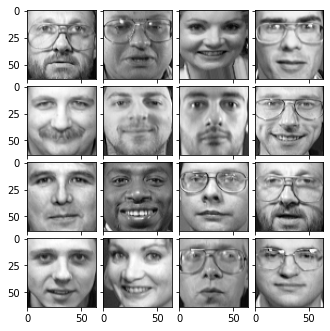

In [82]:
# Examine some of the data 
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 222,
                 nrows_ncols=(4, 4), 
                 axes_pad=0.1)

for ax, im in zip(grid, oliv_dataset['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')

In [83]:
from localmodules.local_binary_patterns import LBP

# LBP feature extraction of the LFW_people Dataset images 
desc_LBP_oliv = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_LBP_oliv = desc_LBP_oliv.describe_list(oliv_dataset.images)
print("LBP feature descriptors' array or arrays shape",embedded_LBP_oliv.shape)

LBP feature descriptors' array or arrays shape (400, 490)


PCA num_components 25
PCA feature descriptors' array or arrays shape (400, 25)


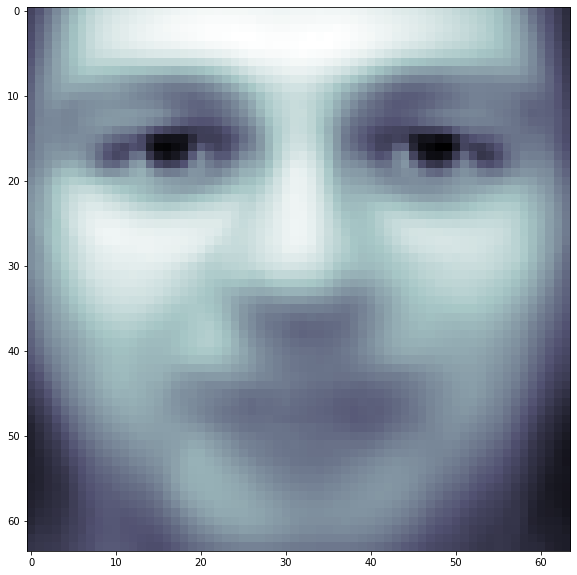

In [84]:
# PCA feature extraction of the LFW_people Dataset images 
num_components_PCA = min(num_components, min(n_classes - 1, n_features))     

print("PCA num_components {n}".format(n=num_components_PCA))

desc_PCA_oliv= PCA(n_components = num_components_PCA, svd_solver='randomized', whiten=True).fit(oliv_dataset.data)
embedded_PCA_oliv = desc_PCA_oliv.transform(oliv_dataset.data)
print("PCA feature descriptors' array or arrays shape",embedded_PCA_oliv.shape)

#Mean face with PCA with LFW dataset
plt.imshow(desc_PCA_oliv.mean_.reshape(oliv_dataset.images[0].shape), cmap=plt.cm.bone)

In [85]:
# LDA feature extraction of the LFW_people Dataset images 
print("Number of images in the LFW_people Dataset= ",len(oliv_dataset.images))

num_components_LDA = min(num_components, min(n_classes - 1, n_features))
print("LDA num_components= {n}".format(n=num_components_LDA))

desc_LDA_oliv = LinearDiscriminantAnalysis(n_components = num_components_LDA).fit(oliv_dataset.data, oliv_dataset.target)
X_LDA = desc_LDA_oliv.fit_transform(oliv_dataset.data, oliv_dataset.target)
embedded_LDA_oliv = X_LDA
print("LDA feature descriptors' array or arrays shape",embedded_LDA_oliv.shape)

Number of images in the LFW_people Dataset=  400
LDA num_components= 25
LDA feature descriptors' array or arrays shape (400, 25)


In [86]:
# Preparing the images from the AT&T - Olivetti faces dataset to train the siamese network with and extract feature arrays
feat_data_DL, images_DL, labels_DL = [], [], []

faces_DL = oliv_dataset.images
face_size = (47,47)

for face,label in zip(faces_DL,oliv_dataset.target):
    # iterate faces found in image
    face = cv2.resize(face, face_size)
    face_flatten = face.flatten()
    images_DL.append(np.expand_dims(face, axis=-1)), feat_data_DL.append(face_flatten), labels_DL.append(label)

# encode classes as integer value
targets_DL = label_encoder.fit_transform(labels_DL)

faces_oliv_DL = Bunch(data      = np.array(feat_data_DL), 
                     images     = np.array(images_DL), 
                     labels     = np.array(labels_DL),
                     target     = np.array(targets_DL))

print("faces_lfw_DL.images shape= ",faces_oliv_DL.images.shape)

faces_lfw_DL.images shape=  (400, 47, 47, 1)


In [87]:
imshape  = (47,47,1)

# DL - siamese network feature extraction of the AT&T - Oliveti faces Dataset images 
import localmodules.siamese as siamese

encoder, model_OLIV = siamese.create_siamese_model(imshape)
#model_OLIV.summary()
x_train_OLIV, x_test_OLIV, y_train_OLIV, y_test_OLIV = holdout_split(*siamese.get_siamese_paired_data(faces_oliv_DL.images, oliv_dataset.target))

model_OLIV.compile(
    loss=siamese.contrastive_loss, 
    optimizer= 'Adam', 
    metrics = [siamese.accuracy],
    run_eagerly=True)

epochs = 10
model_OLIV.fit([x_train_OLIV[:, 0], x_train_OLIV[:, 1]], y_train_OLIV, 
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

test_scores_OLIV = model_OLIV.predict([x_test_OLIV[:, 0], x_test_OLIV[:, 1]])
test_acc_OLIV = accuracy_score(y_test_OLIV, test_scores_OLIV > 0.5)
print("Accuracy on the test set: {}".format(test_acc_OLIV))
embedded_DL_oliv = encoder(faces_oliv_DL.images.astype(np.float32)).numpy()
print("DL-siamese network feature descriptors' array or arrays shape",embedded_DL_oliv.shape)

Epoch 1/10
38/38 - 1s - loss: 0.1803 - accuracy: 0.5683 - val_loss: 0.1077 - val_accuracy: 0.6917
Epoch 2/10
38/38 - 1s - loss: 0.0826 - accuracy: 0.7368 - val_loss: 0.0806 - val_accuracy: 0.7469
Epoch 3/10
38/38 - 1s - loss: 0.0640 - accuracy: 0.8232 - val_loss: 0.0615 - val_accuracy: 0.8146
Epoch 4/10
38/38 - 1s - loss: 0.0524 - accuracy: 0.8586 - val_loss: 0.0550 - val_accuracy: 0.8604
Epoch 5/10
38/38 - 1s - loss: 0.0449 - accuracy: 0.8873 - val_loss: 0.0476 - val_accuracy: 0.8792
Epoch 6/10
38/38 - 1s - loss: 0.0404 - accuracy: 0.9062 - val_loss: 0.0442 - val_accuracy: 0.8917
Epoch 7/10
38/38 - 1s - loss: 0.0376 - accuracy: 0.9243 - val_loss: 0.0418 - val_accuracy: 0.9042
Epoch 8/10
38/38 - 1s - loss: 0.0355 - accuracy: 0.9268 - val_loss: 0.0408 - val_accuracy: 0.9198
Epoch 9/10
38/38 - 1s - loss: 0.0337 - accuracy: 0.9416 - val_loss: 0.0360 - val_accuracy: 0.9354
Epoch 10/10
38/38 - 1s - loss: 0.0315 - accuracy: 0.9441 - val_loss: 0.0364 - val_accuracy: 0.9229
Accuracy on the tes

## AT&T - Olivetti faces dataset - Evaluation

In [88]:
# ground truth labels | distance scores
labels_LBP_oliv,             scores_LBP_oliv  = dist2scores2(embedded_LBP_oliv,faces_oliv_DL)
labels_PCA_oliv,             scores_PCA_oliv  = dist2scores2(embedded_PCA_oliv,faces_oliv_DL)
labels_LDA_oliv,             scores_LDA_oliv  = dist2scores2(embedded_LDA_oliv,faces_oliv_DL)
labels_DL_oliv,              scores_DL_oliv   = dist2scores2(embedded_DL_oliv,faces_oliv_DL)

In [89]:
# Two images are considered to belong to the same person if their feature descriptors do not exceed a distance threshold  

step = 100 #number of different threshold values
thresh = np.linspace(0,1,step)

# Classify the genuine and impostor scores for different thresholds
# y_pred holds the predicted labels of the matching scores
y_pred_LBP_oliv = []
y_pred_PCA_oliv = []
y_pred_LDA_oliv = []
y_pred_DL_oliv = []

# For a range of different thresholds, create the label predictions y for every feature extractor
for i,thr in enumerate(thresh):
    y_pred_LBP_oliv.append(Classifier(thr,scores_LBP_oliv))
    y_pred_PCA_oliv.append(Classifier(thr,scores_PCA_oliv))
    y_pred_LDA_oliv.append(Classifier(thr,scores_LDA_oliv))
    y_pred_DL_oliv.append(Classifier(thr,scores_DL_oliv))
       
y_pred_LBP_oliv = np.array(y_pred_LBP_oliv)
y_pred_PCA_oliv = np.array(y_pred_PCA_oliv)
y_pred_LDA_oliv = np.array(y_pred_LDA_oliv)
y_pred_DL_oliv = np.array(y_pred_DL_oliv)


# Accuracy and F1-scores are calculated for different threshold values, for each feature extraction method

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Initializations
Accuracy_LBP_oliv = np.zeros(step)
Accuracy_PCA_oliv = np.zeros(step)
Accuracy_LDA_oliv = np.zeros(step)
Accuracy_DL_oliv = np.zeros(step)

F1_LBP_oliv = np.zeros(step)
F1_PCA_oliv = np.zeros(step)
F1_LDA_oliv = np.zeros(step)
F1_DL_oliv  = np.zeros(step)

# For a range of different thresholds, create the label predictions y for every feature extractor
for i,thr in enumerate(thresh):  
    # Accuracy and F1 score calculation across multiple thresholds - Accuracy is calculated based on the predicted labels and the ground truth labels for the scores
    # Feature Extractor: Local Binary Pattern (LBA)
    Accuracy_LBP_oliv[i]= accuracy_score(labels_LBP_oliv, y_pred_LBP_oliv[i])
    F1_LBP_oliv[i] = f1_score(labels_LBP_oliv, y_pred_LBP_oliv[i])
    
    # Feature Extractor: Principal Component Analysis (PCA)
    Accuracy_PCA_oliv[i]= accuracy_score(labels_PCA_oliv, y_pred_PCA_oliv[i])
    F1_PCA_oliv[i] = f1_score(labels_PCA_oliv, y_pred_PCA_oliv[i])
    
    # Feature Extractor: Linear Discriminant Analysis (LDA)
    Accuracy_LDA_oliv[i]= accuracy_score(labels_LDA_oliv, y_pred_LDA_oliv[i])
    F1_LDA_oliv[i] = f1_score(labels_LDA_oliv, y_pred_LDA_oliv[i])
    
    # Feature Extractor: Deep Learning (DL)
    Accuracy_DL_oliv[i]= accuracy_score(labels_DL_oliv, y_pred_DL_oliv[i])
    F1_DL_oliv[i] = f1_score(labels_DL_oliv, y_pred_DL_oliv[i])

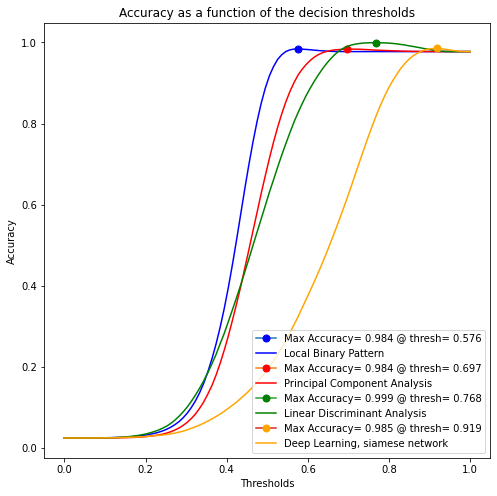

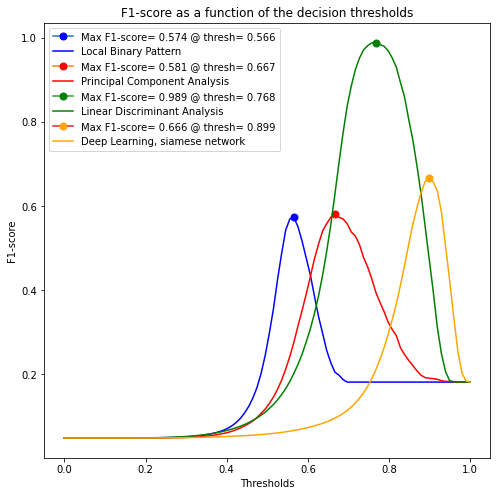

In [90]:
# Thresholds for which F1-scores are maximum for each feature extractor
thr1_F1_oliv = np.argmax(F1_LBP_oliv)
thr2_F1_oliv = np.argmax(F1_PCA_oliv)
thr3_F1_oliv = np.argmax(F1_LDA_oliv)
thr4_F1_oliv = np.argmax(F1_DL_oliv)

# Thresholds for which Accuracy is maximum for each feature extractor
thr1_Acc_oliv = np.argmax(Accuracy_LBP_oliv)
thr2_Acc_oliv = np.argmax(Accuracy_PCA_oliv)
thr3_Acc_oliv = np.argmax(Accuracy_LDA_oliv)
thr4_Acc_oliv = np.argmax(Accuracy_DL_oliv)

plt.rcParams['figure.figsize'] = [8,8]    
plt.title('Accuracy as a function of the decision thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')

plt.plot(thresh[thr1_Acc_oliv], Accuracy_LBP_oliv[thr1_Acc_oliv], marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",
         label="Max Accuracy= "+ str(round(Accuracy_LBP_oliv[thr1_Acc_oliv],3)) + " @ thresh= " + str(round(thresh[thr1_Acc_oliv],3)))
plt.plot(thresh, Accuracy_LBP_oliv, color='blue',label="Local Binary Pattern")

plt.plot(thresh[thr2_Acc_oliv], Accuracy_PCA_oliv[thr2_Acc_oliv], marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",
         label="Max Accuracy= "+ str(round(Accuracy_PCA_oliv[thr2_Acc_oliv],3)) + " @ thresh= " + str(round(thresh[thr2_Acc_oliv],3)))
plt.plot(thresh, Accuracy_PCA_oliv, color='red',label="Principal Component Analysis")

plt.plot(thresh[thr3_Acc_oliv], Accuracy_LDA_oliv[thr3_Acc_oliv], marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",
        label="Max Accuracy= "+ str(round(Accuracy_LDA_oliv[thr3_Acc_oliv],3)) + " @ thresh= " + str(round(thresh[thr3_Acc_oliv],3)))
plt.plot(thresh, Accuracy_LDA_oliv, color='green',label="Linear Discriminant Analysis")

plt.plot(thresh[thr4_Acc_oliv], Accuracy_DL_oliv[thr4_Acc_oliv], marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",
        label="Max Accuracy= "+ str(round(Accuracy_DL_oliv[thr4_Acc_oliv],3)) + " @ thresh= " + str(round(thresh[thr4_Acc_oliv],3)))
plt.plot(thresh, Accuracy_DL_oliv, color='orange',label="Deep Learning, siamese network")

plt.legend(loc="lower right")
plt.show() 

#---------------------------------------------------------------------------
plt.title('F1-score as a function of the decision thresholds')
plt.xlabel('Thresholds')
plt.ylabel('F1-score')

plt.plot(thresh[thr1_F1_oliv], F1_LBP_oliv[thr1_F1_oliv], marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",
         label="Max F1-score= "+ str(round(F1_LBP_oliv[thr1_F1_oliv],3)) + " @ thresh= " + str(round(thresh[thr1_F1_oliv],3)))
plt.plot(thresh, F1_LBP_oliv, color='blue',label="Local Binary Pattern")

plt.plot(thresh[thr2_F1_oliv], F1_PCA_oliv[thr2_F1_oliv], marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",
        label="Max F1-score= "+ str(round(F1_PCA_oliv[thr2_F1_oliv],3)) + " @ thresh= " + str(round(thresh[thr2_F1_oliv],3)))
plt.plot(thresh, F1_PCA_oliv, color='red',label="Principal Component Analysis")

plt.plot(thresh[thr3_F1_oliv], F1_LDA_oliv[thr3_F1_oliv], marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",
        label="Max F1-score= "+ str(round(F1_LDA_oliv[thr3_F1_oliv],3)) + " @ thresh= " + str(round(thresh[thr3_F1_oliv],3)))
plt.plot(thresh, F1_LDA_oliv, color='green',label="Linear Discriminant Analysis")

plt.plot(thresh[thr4_F1_oliv], F1_DL_oliv[thr4_F1_oliv], marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",
        label="Max F1-score= "+ str(round(F1_DL_oliv[thr4_F1_oliv],3)) + " @ thresh= " + str(round(thresh[thr4_F1_oliv],3)))
plt.plot(thresh, F1_DL_oliv, color='orange',label="Deep Learning, siamese network")

plt.legend(loc="upper left")
plt.show() 

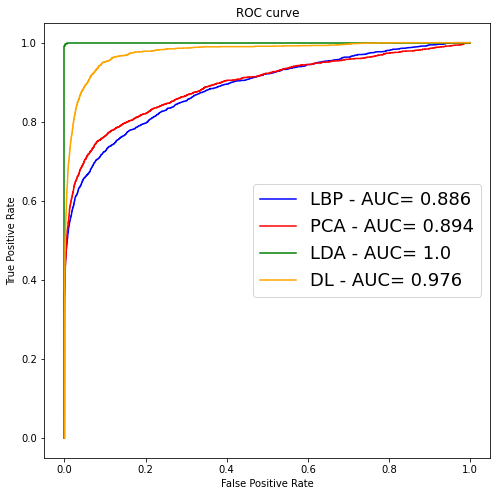

AUC_LBP =  0.8862962435897437
AUC_PCA =  0.8935912564102565
AUC_LDA =  0.9999193974358974
AUC_DL =  0.9762680352564103


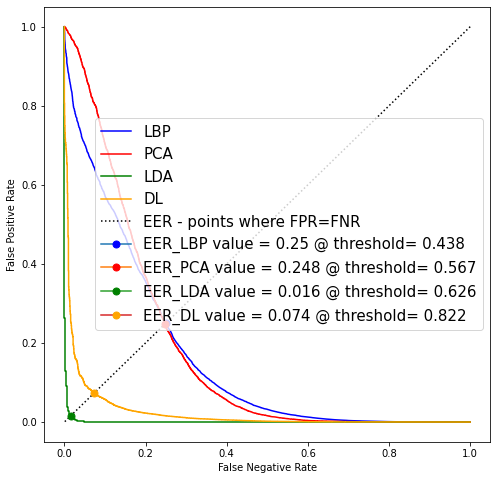

In [91]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#from sklearn.metrics import from_predictions

#                                      ground truth labels  | predicted labels
fpr_LBP, tpr_LBP, thresholds = roc_curve(labels_LBP_oliv, scores_LBP_oliv) # 

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_LBP, tpr_LBP, color='blue',label="LBP - AUC= " + str(round(auc(fpr_LBP, tpr_LBP),3)))

fpr_PCA, tpr_PCA, thresholds = roc_curve(labels_PCA_oliv, scores_PCA_oliv) 
plt.plot(fpr_PCA, tpr_PCA, color='red',label="PCA - AUC= " + str(round(auc(fpr_PCA, tpr_PCA),3)))

fpr_LDA, tpr_LDA, thresholds = roc_curve(labels_LDA_oliv, scores_LDA_oliv) 
plt.plot(fpr_LDA, tpr_LDA, color='green',label="LDA - AUC= " + str(round(auc(fpr_LDA, tpr_LDA),3)))

fpr_DL, tpr_DL, thresholds = roc_curve(labels_DL_oliv, scores_DL_oliv) 
plt.plot(fpr_DL, tpr_DL, color='orange',label="DL - AUC= " + str(round(auc(fpr_DL, tpr_DL),3)))

plt.legend(loc="right",prop={'size': 18})
plt.show()


# AUC Calculation
from sklearn.metrics import auc

print("AUC_LBP = ",auc(fpr_LBP, tpr_LBP))
print("AUC_PCA = ",auc(fpr_PCA, tpr_PCA))
print("AUC_LDA = ",auc(fpr_LDA, tpr_LDA))
print("AUC_DL = ",auc(fpr_DL, tpr_DL))

# Calculation of EER points and corresponding thresholds

fpr_LBP, tpr_LBP, thresholds_LBP = roc_curve(labels_LBP, scores_LBP) 
fnr_LBP = 1 - tpr_LBP
plt.xlabel('False Negative Rate')
plt.ylabel('False Positive Rate')
plt.plot(fnr_LBP, fpr_LBP, color='blue',label="LBP")

fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(labels_PCA, scores_PCA) 
fnr_PCA = 1 - tpr_PCA
plt.plot(fnr_PCA, fpr_PCA, color='red',label="PCA")

fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(labels_LDA, scores_LDA) 
fnr_LDA = 1 - tpr_LDA
plt.plot(fnr_LDA, fpr_LDA, color='green',label="LDA")

fpr_DL, tpr_DL, thresholds_DL = roc_curve(labels_DL_oliv, scores_DL_oliv) 
fnr_DL = 1 - tpr_DL
plt.plot(fnr_DL, fpr_DL, color='orange',label="DL")

# EER line- where FNR 
plt.plot(fnr_DL, fnr_DL, linestyle='dotted',color='black',label="EER - points where FPR=FNR")


# Equal Error Rate points (only one coordinate needed since FPR=FNR for the EER points)
EER_LBP = fpr_LBP[np.nanargmin(np.absolute((fnr_LBP - fpr_LBP)))]
thr_EER_LBP = thresholds_LBP[np.nanargmin(np.absolute((fnr_LBP - fpr_LBP)))]

EER_PCA = fpr_PCA[np.nanargmin(np.absolute((fnr_PCA - fpr_PCA)))]
thr_EER_PCA = thresholds_PCA[np.nanargmin(np.absolute((fnr_PCA - fpr_PCA)))]

EER_LDA = fpr_LDA[np.nanargmin(np.absolute((fnr_LDA - fpr_LDA)))]
thr_EER_LDA = thresholds_LDA[np.nanargmin(np.absolute((fnr_LDA - fpr_LDA)))]

EER_DL = fpr_DL[np.nanargmin(np.absolute((fnr_DL - fpr_DL)))]
thr_EER_DL = thresholds_DL[np.nanargmin(np.absolute((fnr_DL - fpr_DL)))]


# EER points
plt.plot(EER_LBP, EER_LBP, marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue",label = "EER_LBP value = "+str(round(EER_LBP,3))+" @ threshold= "+ str(round(thr_EER_LBP,3)))
plt.plot(EER_PCA, EER_PCA, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red",label = "EER_PCA value = "+str(round(EER_PCA,3))+" @ threshold= "+ str(round(thr_EER_PCA,3)))
plt.plot(EER_LDA, EER_LDA, marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green",label = "EER_LDA value = "+str(round(EER_LDA,3))+" @ threshold= "+ str(round(thr_EER_LDA,3)))
plt.plot(EER_DL, EER_DL, marker="o", markersize=7, markeredgecolor="orange", markerfacecolor="orange",label = "EER_DL value = "+str(round(EER_DL,3))+" @ threshold= "+ str(round(thr_EER_DL,3)))

plt.legend(loc="right",prop={'size': 15})
plt.show()